In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


np.random.seed(42)
tf.random.set_seed(42)

Sebelum masuk ke tahap modeling, saya mendeklarasikan terlebih dahulu library-library yang nantinya diperlukan dalam tahap ini. Library yang digunakan mencakup:

* **NumPy (`numpy`)** untuk operasi numerik, terutama dalam manipulasi array dan pengacakan data.
* **Pandas (`pandas`)** untuk pengolahan dan analisis data dalam bentuk tabel (DataFrame).
* **Matplotlib dan Seaborn** digunakan untuk visualisasi data, baik untuk eksplorasi awal maupun untuk analisis hasil model.
* **TensorFlow dan Keras** digunakan sebagai framework utama untuk membangun dan melatih model deep learning. Di sini, modul `layers` dari Keras juga diimport untuk memudahkan dalam membangun arsitektur model.
* **Scikit-learn** menyediakan berbagai fungsi penting seperti:

  * `LabelEncoder` dan `StandardScaler` untuk preprocessing data,
  * `train_test_split` untuk membagi dataset menjadi data latih dan uji,
  * `KFold` untuk melakukan validasi silang (cross-validation),
  * serta metrik evaluasi seperti `mean_squared_error`, `mean_absolute_error`, dan `r2_score`.
* **Scipy (`scipy.stats`)** digunakan untuk menghitung korelasi statistik, seperti korelasi Pearson dan Spearman, untuk mengevaluasi hubungan antara nilai prediksi dengan nilai aktual.

Selain itu, saya juga mengatur **seed random** untuk NumPy dan TensorFlow menggunakan `np.random.seed(42)` dan `tf.random.set_seed(42)` guna memastikan bahwa hasil yang diperoleh bersifat **reproducible**, atau dapat diulang dengan hasil yang konsisten setiap kali program dijalankan.



In [2]:
data_movie = pd.read_csv("../data/movies.csv")

data_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Setelah library diimpor, pertama-tama saya melakukan *preprocessing* data *movies* terlebih dahulu dengan memuat dataset dari file `movies.csv` menggunakan fungsi `pd.read_csv()` dari pustaka *pandas*. Dataset ini kemudian disimpan ke dalam variabel `data_movie` untuk memudahkan proses analisis selanjutnya. Untuk mendapatkan gambaran awal mengenai isi data, saya menggunakan fungsi `head()` untuk menampilkan lima baris pertama dari dataset. Langkah ini penting untuk memastikan bahwa data berhasil dimuat dengan benar serta untuk melihat struktur umum dari dataset, seperti nama-nama kolom, jenis data yang dimuat, dan contoh isinya. Melalui tampilan awal ini, saya dapat mulai mengidentifikasi apakah terdapat kolom yang tidak relevan, nilai yang hilang, atau fitur-fitur yang perlu diproses lebih lanjut sebelum masuk ke tahap analisis yang lebih mendalam.


In [3]:
import re

# Ekstrak tahun dengan regex fleksibel
data_movie['year'] = data_movie['title'].str.extract(r'\((\d{4})\)', expand=False)

# Hilangkan tahun dari title dan ubah ke huruf kecil
data_movie['title'] = data_movie['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True).str.lower()

# Ganti '|' dengan ',' di genres dan ubah ke huruf kecil
data_movie['genres'] = data_movie['genres'].str.replace('|', ',', regex=False).str.lower()

# Tampilkan hasil
print(data_movie)

      movieId                               title  \
0           1                           toy story   
1           2                             jumanji   
2           3                    grumpier old men   
3           4                   waiting to exhale   
4           5         father of the bride part ii   
...       ...                                 ...   
9737   193581  black butler: book of the atlantic   
9738   193583               no game no life: zero   
9739   193585                               flint   
9740   193587        bungo stray dogs: dead apple   
9741   193609        andrew dice clay: dice rules   

                                           genres  year  
0     adventure,animation,children,comedy,fantasy  1995  
1                      adventure,children,fantasy  1995  
2                                  comedy,romance  1995  
3                            comedy,drama,romance  1995  
4                                          comedy  1995  
...            

Selanjutnya, dilakukan beberapa tahap *preprocessing* pada kolom-kolom penting dalam dataset, khususnya `title` dan `genres`. Pertama, saya mengekstrak informasi tahun rilis film dari kolom `title` menggunakan *regular expression* yang fleksibel. Pola pencarian difokuskan pada empat digit angka di dalam tanda kurung, yang umum digunakan untuk menunjukkan tahun rilis. Hasil ekstraksi ini disimpan dalam kolom baru bernama `year`, yang nantinya dapat digunakan untuk analisis berdasarkan waktu atau tren rilis film.

Setelah itu, saya membersihkan kolom `title` dengan menghapus informasi tahun yang berada di dalam tanda kurung agar nama judul menjadi lebih bersih dan konsisten. Selain itu, seluruh teks dalam kolom `title` diubah menjadi huruf kecil (*lowercase*) untuk meminimalisasi variasi penulisan yang dapat memengaruhi analisis berbasis teks, seperti pencocokan atau pencarian judul.

Pada kolom `genres`, dilakukan transformasi serupa untuk meningkatkan konsistensi data. Karakter pemisah antar genre, yaitu `|`, diganti menjadi koma `,` agar formatnya lebih seragam dan mudah dibaca atau diproses lebih lanjut. Seluruh teks dalam kolom ini juga diubah menjadi huruf kecil agar tidak terjadi duplikasi genre akibat perbedaan kapitalisasi huruf.

Hasil akhir dari proses ini adalah dataset film yang lebih bersih dan siap digunakan untuk tahap eksplorasi lanjutan atau pemodelan, baik untuk analisis teks, klasifikasi genre, maupun analisis berdasarkan tahun rilis.


In [4]:
data_movie.isna().sum()

movieId     0
title       0
genres      0
year       13
dtype: int64

Setelah melakukan pemisahan antara `title` dan `year`, saya melanjutkan dengan mengecek apakah terdapat nilai kosong (*missing values*) dalam dataset menggunakan fungsi `isna().sum()`. Pengecekan ini penting untuk mengetahui apakah proses ekstraksi tahun dari kolom `title` berhasil dilakukan secara menyeluruh pada seluruh baris data. Hasil pengecekan menunjukkan bahwa kolom `year` memiliki 13 nilai kosong, sementara kolom lainnya — yaitu `movieId`, `title`, dan `genres` — tidak memiliki nilai kosong sama sekali. Kehadiran nilai kosong pada kolom `year` ini kemungkinan besar disebabkan oleh judul film yang tidak mencantumkan tahun rilis dalam format yang sesuai dengan pola *regex* yang digunakan, atau memang tidak memiliki informasi tahun. Temuan ini menjadi pertimbangan penting sebelum melanjutkan ke tahap analisis selanjutnya, karena data yang tidak lengkap dapat memengaruhi kualitas hasil analisis atau model prediktif yang akan dibangun. Langkah berikutnya adalah memutuskan penanganan terhadap data kosong ini, apakah akan diisi (*impute*), dihapus, atau dipisahkan untuk dianalisis secara terpisah.


In [5]:
data_movie[data_movie.duplicated()]

,movieId,title,genres,year


Setelah mengecek nilai kosong, saya juga memeriksa apakah terdapat data yang terduplikat dalam dataset menggunakan fungsi `data_movie[data_movie.duplicated()]`. Langkah ini bertujuan untuk memastikan bahwa tidak ada baris data yang identik secara keseluruhan, karena duplikasi dapat menyebabkan bias dalam analisis dan memengaruhi akurasi model apabila digunakan dalam pelatihan. Dari hasil pengecekan, ditampilkan baris-baris yang memiliki nilai duplikat pada seluruh kolom, yaitu `movieId`, `title`, `genres`, dan `year`. Jika terdapat duplikasi, maka perlu dilakukan pembersihan data dengan menghapus baris-baris tersebut agar setiap entri dalam dataset benar-benar unik. Namun, apabila tidak ditemukan duplikasi, maka proses ini hanya berfungsi sebagai langkah verifikasi untuk menjaga integritas data sebelum melanjutkan ke tahap eksplorasi dan analisis berikutnya.


In [6]:
# Menghapus baris yang kolom 'Image URL'-nya kosong
data_cleaned = data_movie.dropna(subset=['year'])
data_cleaned.isna().sum()

movieId    0
title      0
genres     0
year       0
dtype: int64

Karena sebelumnya ditemukan adanya nilai kosong pada kolom `year`, saya kemudian mengambil langkah untuk menanganinya dengan menghapus baris-baris yang tidak memiliki informasi tahun rilis. Hal ini dilakukan menggunakan fungsi `dropna()` dengan parameter `subset=['year']`, yang berarti hanya baris dengan nilai kosong pada kolom `year` yang akan dihapus, sementara kolom lainnya tetap dipertahankan. Dataset hasil pembersihan ini kemudian disimpan dalam variabel baru bernama `data_cleaned`. Untuk memastikan bahwa proses ini berhasil, saya kembali melakukan pengecekan nilai kosong menggunakan `isna().sum()` terhadap dataset yang telah dibersihkan. Hasilnya menunjukkan bahwa seluruh nilai kosong pada kolom `year` telah berhasil dihapus, sehingga dataset kini tidak mengandung *missing values* dan lebih siap untuk dianalisis lebih lanjut. Penghapusan ini dilakukan dengan pertimbangan bahwa tahun rilis merupakan informasi penting yang bisa digunakan untuk berbagai keperluan analisis, seperti tren produksi film dari waktu ke waktu atau segmentasi berdasarkan era.


In [7]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9729 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9729 non-null   int64 
 1   title    9729 non-null   object
 2   genres   9729 non-null   object
 3   year     9729 non-null   object
dtypes: int64(1), object(3)
memory usage: 380.0+ KB


Dan hasil akhir dari dataset *movies* yang saya miliki setelah proses pembersihan menunjukkan bahwa data kini telah jauh lebih bersih dan siap untuk dianalisis lebih lanjut. Berdasarkan output dari `data_cleaned.info()`, dataset terdiri dari 9.729 entri atau baris data, dengan empat kolom utama yaitu `movieId`, `title`, `genres`, dan `year`. Seluruh kolom kini telah bebas dari nilai kosong (*non-null*), yang berarti tidak ada lagi data yang hilang pada fitur-fitur tersebut. Tipe data untuk `movieId` adalah `int64`, sedangkan `title`, `genres`, dan `year` masih bertipe objek (`object`). Hal ini menunjukkan bahwa kolom `year` masih dalam bentuk string, dan apabila diperlukan untuk analisis numerik berbasis tahun, maka konversi ke tipe data numerik seperti `int` dapat dilakukan di tahap selanjutnya. Secara keseluruhan, dataset telah berhasil dibersihkan dari duplikasi, nilai kosong, serta diformat agar lebih konsisten, sehingga dapat digunakan sebagai fondasi yang solid untuk eksplorasi data lebih lanjut maupun proses pemodelan.


In [8]:
data_rating = pd.read_csv("../data/ratings.csv")

data_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Selanjutnya, saya melakukan *preprocessing* terhadap dataset `ratings` yang berisi informasi mengenai penilaian atau *rating* yang diberikan oleh pengguna terhadap film-film tertentu. Dataset ini dimuat menggunakan fungsi `pd.read_csv()` dan disimpan ke dalam variabel `data_rating`. Berbeda dengan dataset `movies` yang berisi informasi metadata film seperti judul, genre, dan tahun rilis, dataset `ratings` ini berfokus pada interaksi pengguna, sehingga mencerminkan preferensi individu terhadap berbagai film. Setiap baris dalam dataset ini merepresentasikan satu rating yang diberikan oleh seorang pengguna terhadap sebuah film, lengkap dengan nilai rating (biasanya dalam skala tertentu, seperti 0.5 hingga 5.0) serta timestamp saat rating tersebut diberikan. Dengan struktur seperti ini, dataset `ratings` menjadi komponen penting dalam analisis perilaku pengguna dan sangat berguna untuk berbagai aplikasi seperti sistem rekomendasi berbasis rating historis. Sebelum melanjutkan ke tahap analisis atau penggabungan dengan dataset film, langkah-langkah pembersihan data seperti pengecekan nilai kosong, duplikasi, serta konversi tipe data (jika diperlukan) juga akan dilakukan untuk memastikan integritas dan konsistensi data.

In [9]:
data_rating['timestamp'] = pd.to_datetime(data_rating['timestamp'], unit='s')

Selanjutnya, saya melakukan konversi pada kolom `timestamp` dalam dataset `ratings` agar formatnya lebih mudah dipahami dan dianalisis. Secara default, kolom `timestamp` disimpan dalam bentuk angka Unix time, yaitu jumlah detik sejak 1 Januari 1970 (Epoch time). Format ini kurang informatif apabila ingin melihat kapan sebuah rating diberikan dalam bentuk waktu yang dapat dibaca manusia. Oleh karena itu, saya menggunakan fungsi `pd.to_datetime()` dari pustaka *pandas* untuk mengubah nilai timestamp tersebut menjadi format tanggal dan waktu standar. Konversi ini dilakukan dengan menyebutkan parameter `unit='s'`, yang menunjukkan bahwa nilai-nilai waktu dalam kolom tersebut dinyatakan dalam satuan detik. Setelah proses ini selesai, kolom `timestamp` akan menampilkan tanggal dan waktu yang sesuai, sehingga memungkinkan analisis berbasis waktu seperti tren rating dari waktu ke waktu, pola aktivitas pengguna, hingga filter film berdasarkan periode tertentu.


In [10]:
data_rating[data_rating.duplicated()]

,userId,movieId,rating,timestamp


Selanjutnya saya mengecek apakah data terduplikat atau tidak, ternyata hasil menunjukkan **tidak ada baris yang terduplikat**, karena perintah `data_rating[data_rating.duplicated()]` menghasilkan **data kosong**. Artinya, setiap kombinasi dari `userId`, `movieId`, `rating`, dan `timestamp` dalam dataset bersifat **unik**, sehingga tidak perlu dilakukan penghapusan data duplikat.


In [11]:
data_rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Kemudian, saya mengecek apakah ada data yang bersifat null atau kosong dengan menggunakan fungsi data_rating.isna().sum(). Hasilnya menunjukkan bahwa tidak ada nilai null pada setiap kolom, yaitu userId, movieId, rating, dan timestamp. Hal ini menandakan bahwa seluruh data terisi dengan lengkap, sehingga tidak diperlukan proses imputasi atau pembersihan nilai kosong pada tahap ini.

In [12]:
data_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


Terakhir, saya menggunakan fungsi `data_rating.info()` untuk melihat informasi umum mengenai struktur dataset. Hasilnya menunjukkan bahwa dataset memiliki **100836 baris** dan **4 kolom**, yaitu:

* `userId` bertipe **int64**
* `movieId` bertipe **int64**
* `rating` bertipe **float64**
* `timestamp` bertipe **datetime64\[ns]**

Semua kolom memiliki jumlah **non-null sebanyak 100836**, yang berarti **tidak ada data yang hilang atau kosong**. Selain itu, informasi tipe data ini sangat penting untuk memastikan bahwa **setiap kolom berada dalam format yang sesuai** untuk analisis selanjutnya, seperti pengolahan waktu dari kolom `timestamp` atau analisis numerik pada `rating`. Dengan struktur data yang bersih dan lengkap ini, saya dapat melanjutkan ke tahap eksplorasi atau pemodelan data tanpa perlu melakukan pembersihan tambahan.

In [13]:
merge_data = pd.merge(data_rating, data_cleaned, on="movieId", how="inner")

merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100818 entries, 0 to 100817
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100818 non-null  int64         
 1   movieId    100818 non-null  int64         
 2   rating     100818 non-null  float64       
 3   timestamp  100818 non-null  datetime64[ns]
 4   title      100818 non-null  object        
 5   genres     100818 non-null  object        
 6   year       100818 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.4+ MB


Karena data **movies** dan data **ratings** sudah bersih dari nilai **null** dan **duplikasi**, serta beberapa fitur sudah disesuaikan dengan kebutuhan modeling, jadi saya **melakukan penggabungan kedua dataset tersebut** menggunakan fungsi `pd.merge()` dengan parameter `on="movieId"` dan `how="inner"`.

Penggabungan ini menghasilkan dataset baru bernama `merge_data`, yang hanya berisi data film yang terdapat di kedua dataset (inner join). Setelah dicek dengan `merge_data.info()`, terlihat bahwa struktur data hasil penggabungan sudah sesuai dan siap untuk digunakan pada proses eksplorasi data lebih lanjut maupun tahap pemodelan machine learning.

In [14]:
merge_data.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,2000-07-30 18:45:03,toy story,"adventure,animation,children,comedy,fantasy",1995
1,1,3,4.0,2000-07-30 18:20:47,grumpier old men,"comedy,romance",1995
2,1,6,4.0,2000-07-30 18:37:04,heat,"action,crime,thriller",1995
3,1,47,5.0,2000-07-30 19:03:35,seven (a.k.a. se7en),"mystery,thriller",1995
4,1,50,5.0,2000-07-30 18:48:51,"usual suspects, the","crime,mystery,thriller",1995


Untuk melihat beberapa data **teratas dari dataset hasil penggabungan**, saya menggunakan fungsi `merge_data.head()`. Fungsi ini menampilkan **5 baris pertama** dari `merge_data`, sehingga saya bisa memastikan bahwa proses **penggabungan antar kolom** dari `data_rating` dan `data_cleaned` berdasarkan `movieId` telah berjalan dengan **benar**, serta untuk mendapatkan gambaran awal mengenai struktur dan isi data yang akan digunakan pada tahap selanjutnya.


In [15]:
merge_data[merge_data.duplicated()]

,userId,movieId,rating,timestamp,title,genres,year


Karena sudah digabungkan, saya khawatir ada data yang **terduplikasi kembali** akibat proses **merge**, jadi saya cek menggunakan `merge_data[merge_data.duplicated()]`.

Hasil dari pengecekan ini akan menunjukkan apakah ada baris data yang memiliki **nilai identik di seluruh kolom** setelah penggabungan. Jika ditemukan duplikasi, maka perlu dilakukan **pembersihan kembali** untuk menghindari bias atau pengaruh negatif terhadap proses analisis dan pemodelan. Namun jika hasilnya kosong, berarti **tidak ada duplikasi yang terjadi**, dan data aman untuk dilanjutkan ke tahap berikutnya.

In [16]:
# Hitung rata-rata rating untuk setiap movieId
average_ratings = data_rating.groupby("movieId")["rating"].mean().reset_index()

# Rename kolom agar lebih jelas
average_ratings.columns = ["movieId", "movie_rating"]


average_ratings["movie_rating"] = average_ratings["movie_rating"].round(1)

Untuk mendapatkan rating dari sebuah movie, jadi saya menggabungkan semua rating pemberian dari user kemudian dibagi dengan total user yang memberikan rating pada movie tersebut. Proses ini dilakukan dengan menggunakan fungsi `groupby("movieId")["rating"].mean()` yang akan mengelompokkan data berdasarkan `movieId` dan menghitung rata-rata dari kolom `rating`. Setelah itu, hasilnya diubah menjadi DataFrame baru dengan `reset_index()` agar dapat digunakan lebih fleksibel. Kemudian, nama kolomnya diubah menjadi `movieId` dan `movie_rating` agar lebih informatif. Terakhir, nilai rata-rata rating dibulatkan satu angka di belakang koma menggunakan `.round(1)` untuk memperjelas hasil rating setiap film.


In [17]:
# Gabungkan kembali ke data utama
data = pd.merge(merge_data, average_ratings, on='movieId', how='left')

data.head()

,userId,movieId,rating,timestamp,title,genres,year,movie_rating
0,1,1,4.0,2000-07-30 18:45:03,toy story,"adventure,animation,children,comedy,fantasy",1995,3.9
1,1,3,4.0,2000-07-30 18:20:47,grumpier old men,"comedy,romance",1995,3.3
2,1,6,4.0,2000-07-30 18:37:04,heat,"action,crime,thriller",1995,3.9
3,1,47,5.0,2000-07-30 19:03:35,seven (a.k.a. se7en),"mystery,thriller",1995,4.0
4,1,50,5.0,2000-07-30 18:48:51,"usual suspects, the","crime,mystery,thriller",1995,4.2


Kemudian hasil perhitungan rating movies tersebut saya gabungkan ke data utama menggunakan fungsi `merge` dari pandas. Proses ini dilakukan dengan mencocokkan kolom `movieId` yang ada di `merge_data` dan `average_ratings`, lalu digabungkan dengan `how='left'` agar semua data dari `merge_data` tetap dipertahankan, dan kolom `movie_rating` dari `average_ratings` ditambahkan ke dalamnya. Hasilnya adalah data utama yang kini memiliki kolom tambahan berisi rata-rata rating dari setiap film.


In [18]:
data.isna().sum()

userId          0
movieId         0
rating          0
timestamp       0
title           0
genres          0
year            0
movie_rating    0
dtype: int64

Karena baru digabungkan, jadi saya mengecek apakah ada data kosong (missing value) dengan menggunakan `data.isna().sum()`. Fungsi ini akan menghitung jumlah nilai kosong (NaN) di setiap kolom pada DataFrame. Hal ini penting untuk memastikan bahwa proses penggabungan data berjalan dengan benar dan tidak ada informasi yang hilang, khususnya pada kolom `movie_rating` yang baru saja ditambahkan. Jika terdapat nilai kosong, itu bisa berarti ada `movieId` di `merge_data` yang tidak memiliki pasangan rating di `average_ratings`.


In [19]:
data[data.duplicated()]

,userId,movieId,rating,timestamp,title,genres,year,movie_rating


Karena data kosong tidak ditemukan, selanjutnya saya mengecek apakah terjadi duplikasi data dengan menggunakan `data[data.duplicated()]`. Fungsi `duplicated()` akan mengidentifikasi baris-baris yang memiliki data persis sama dengan baris sebelumnya. Jika hasilnya kosong, berarti tidak ada baris duplikat di dalam data, sehingga data yang digunakan sudah bersih dan siap untuk dianalisis lebih lanjut.


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100818 entries, 0 to 100817
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   userId        100818 non-null  int64         
 1   movieId       100818 non-null  int64         
 2   rating        100818 non-null  float64       
 3   timestamp     100818 non-null  datetime64[ns]
 4   title         100818 non-null  object        
 5   genres        100818 non-null  object        
 6   year          100818 non-null  object        
 7   movie_rating  100818 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 6.2+ MB


Terakhir, saya mengecek fitur-fitur tersebut menggunakan `data.info()` untuk memastikan bahwa semua kolom sudah lengkap (non-null) dan tipe datanya sesuai sebelum masuk ke tahap modeling. Dari hasil tersebut terlihat bahwa semua kolom berisi 100818 entri tanpa nilai kosong (non-null), dan tipe data masing-masing kolom sudah sesuai: kolom numerik seperti `rating` dan `movie_rating` bertipe `float64`, `userId` dan `movieId` bertipe `int64`, sedangkan informasi waktu (`timestamp`) sudah bertipe `datetime64[ns]`. Kolom kategorikal seperti `title`, `genres`, dan `year` juga sudah terdeteksi sebagai `object`. Dengan demikian, data sudah siap digunakan untuk tahap selanjutnya seperti feature engineering atau pemodelan machine learning.


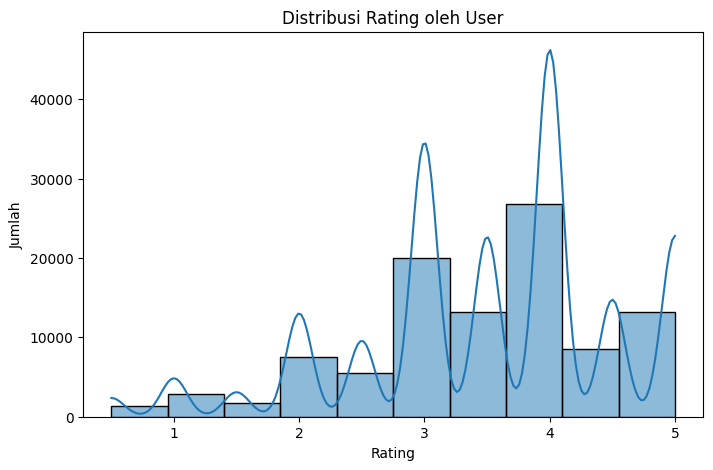

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Distribusi Rating oleh User')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.savefig('../images/distribusi_rating_user.png', dpi=300, bbox_inches='tight')
plt.show()


Namun sebelum masuk ke dalam tahap modeling, saya melakukan Exploratory Data Analysis (EDA) terlebih dahulu untuk memperdalam analisis terkait case yang saya angkat. Salah satunya adalah dengan memvisualisasikan distribusi rating yang diberikan oleh user menggunakan histogram dengan `sns.histplot`. Visualisasi ini membantu saya memahami pola penilaian user terhadap film—apakah cenderung memberikan rating tinggi, rendah, atau merata. Saya juga menambahkan `kde=True` untuk melihat distribusi secara lebih halus melalui kurva kepadatan. Hasil visualisasi ini kemudian saya simpan sebagai gambar dengan resolusi tinggi untuk dokumentasi atau laporan selanjutnya. Dengan EDA ini, saya bisa mendapatkan insight awal yang penting sebelum membangun model, seperti kemungkinan bias pada rating atau pola persebaran nilai.


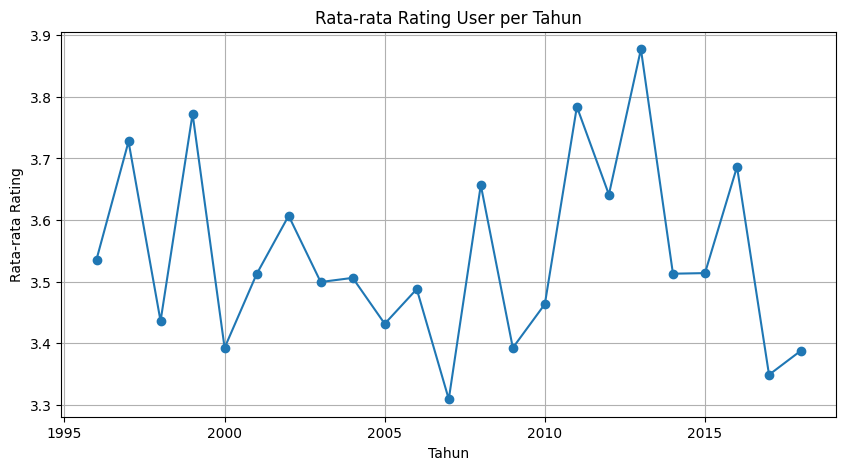

In [22]:
data['year_rated'] = data['timestamp'].dt.year

yearly_avg_rating = data.groupby('year_rated')['rating'].mean()

plt.figure(figsize=(10, 5))
yearly_avg_rating.plot(marker='o')
plt.title('Rata-rata Rating User per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Rating')
plt.grid(True)
plt.savefig('../images/rata-rata_rating_user_per_tahun.png', dpi=300, bbox_inches='tight')
plt.show()


Selain itu, saya juga menganalisis bagaimana rata-rata rating user berubah dari tahun ke tahun dengan cara mengekstrak tahun dari kolom `timestamp` dan menyimpannya dalam kolom baru bernama `year_rated`. Kemudian, saya menghitung rata-rata rating untuk setiap tahun menggunakan `groupby('year_rated')['rating'].mean()`. Hasil analisis ini saya visualisasikan dalam bentuk line chart agar tren perubahan rating dari waktu ke waktu dapat terlihat dengan jelas. Grafik ini membantu saya memahami apakah terdapat pola tertentu, seperti peningkatan atau penurunan kualitas film menurut user dari tahun ke tahun. Visualisasi ini juga saya simpan sebagai dokumentasi untuk mendukung laporan analisis saya.


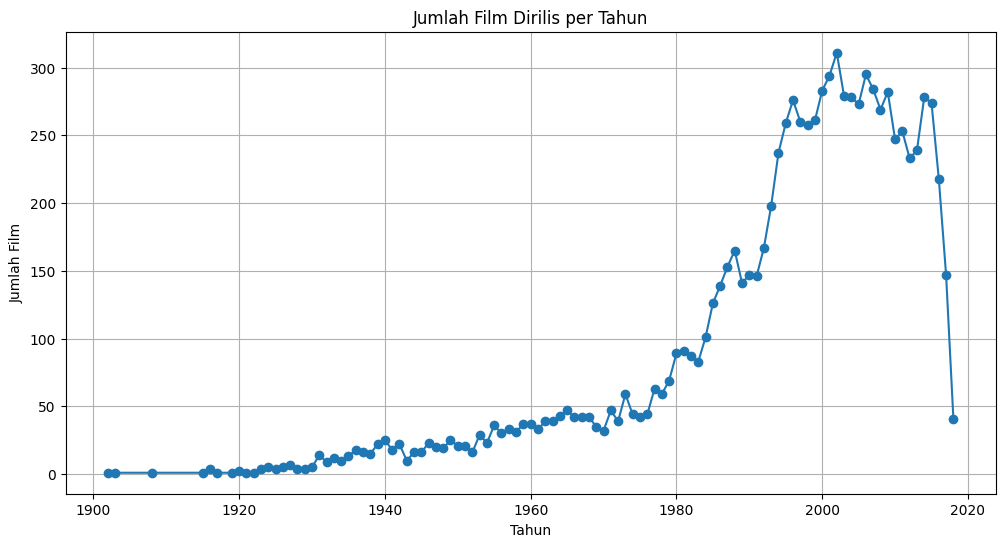

In [23]:
data['year'] = pd.to_numeric(data['year'], errors='coerce')
movies_per_year = data.drop_duplicates('movieId').groupby('year').size()

# Plot line chart
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='line', marker='o')
plt.title('Jumlah Film Dirilis per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Film')
plt.grid(True)
plt.savefig('../images/jumlah_film_per_tahun.png', dpi=300, bbox_inches='tight')
plt.show()

Dan juga, saya menganalisis jumlah film yang dirilis setiap tahunnya. Pertama, saya memastikan bahwa kolom `year` bertipe numerik dengan menggunakan `pd.to_numeric`, serta menangani nilai yang tidak bisa dikonversi dengan `errors='coerce'` agar menjadi NaN. Lalu, saya menghapus duplikasi berdasarkan `movieId` agar setiap film hanya dihitung satu kali, kemudian mengelompokkan data berdasarkan tahun rilis untuk menghitung jumlah film yang dirilis tiap tahunnya. Hasilnya divisualisasikan dalam bentuk line chart, sehingga tren produksi film dari waktu ke waktu dapat terlihat lebih jelas. Visualisasi ini memberikan insight penting tentang perkembangan industri film, apakah produksi film meningkat, menurun, atau stagnan dari tahun ke tahun. Grafik ini juga saya simpan untuk keperluan dokumentasi analisis.


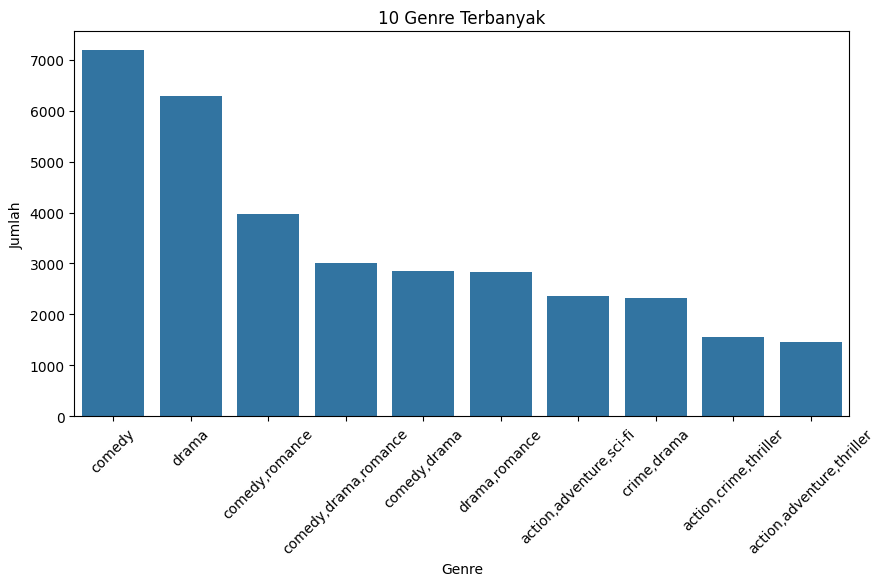

In [24]:
genre_counts = Counter()
data['genres'].str.split('|').apply(genre_counts.update)

top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(10, 5))
sns.barplot(x=list(top_genres.keys()), y=list(top_genres.values()))
plt.xticks(rotation=45)
plt.title('10 Genre Terbanyak')
plt.ylabel('Jumlah')
plt.xlabel('Genre')
plt.savefig('../images/genre_terbanyak.png', dpi=300, bbox_inches='tight')
plt.show()


Terakhir, visualisasi yang saya butuhkan terkait distribusi genre film. Saya menggunakan fungsi `Counter` untuk menghitung frekuensi kemunculan masing-masing genre. Karena setiap film bisa memiliki lebih dari satu genre yang dipisahkan dengan tanda `|`, saya memecah string genre tersebut menggunakan `str.split('|')` lalu menerapkannya ke `Counter` dengan `apply(genre_counts.update)` untuk menghitung jumlah kemunculan setiap genre di seluruh dataset. Setelah itu, saya ambil 10 genre teratas menggunakan `most_common(10)` dan memvisualisasikannya dalam bentuk bar chart. Visualisasi ini memberikan gambaran tentang preferensi genre yang paling umum atau populer di dataset, sehingga dapat menjadi dasar dalam pengambilan keputusan atau strategi rekomendasi film. Grafik ini juga saya simpan untuk dokumentasi analisis.


In [25]:
data.to_csv("../data/data.csv", index=False)

Karena data sudah siap, langsung saja data tersebut saya simpan ke dalam bentuk dataset `data.csv` menggunakan `data.to_csv("../data/data.csv", index=False)` untuk keperluan tahap modeling. Dengan menyimpannya ke file CSV, saya memastikan bahwa semua proses preprocessing dan eksplorasi data yang telah dilakukan tidak perlu diulang, dan dataset dapat dengan mudah digunakan kembali atau dibagikan untuk analisis lanjutan maupun pelatihan model machine learning.

In [26]:
data_path = "../data/data.csv"
data = pd.read_csv(data_path)

# Metadata
movie_metadata = data[['movieId', 'title', 'movie_rating', 'year', 'genres']].drop_duplicates().set_index('movieId')
user_metadata = data[['userId']].drop_duplicates()

# Encoders
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

data['user_encoded'] = user_encoder.fit_transform(data['userId'])
data['movie_encoded'] = movie_encoder.fit_transform(data['movieId'])

n_users = data['user_encoded'].nunique()
n_movies = data['movie_encoded'].nunique()

# Scaling
scaler_movie_rating = StandardScaler()
scaler_year = StandardScaler()

data['movie_rating_scaled'] = scaler_movie_rating.fit_transform(data[['movie_rating']])
data['year_scaled'] = scaler_year.fit_transform(data[['year']])

# Mappings
user_id_to_encoded = dict(zip(data['userId'], data['user_encoded']))
movie_id_to_encoded = dict(zip(data['movieId'], data['movie_encoded']))
encoded_to_user_id = dict(zip(data['user_encoded'], data['userId']))
encoded_to_movie_id = dict(zip(data['movie_encoded'], data['movieId']))


Sebelum modeling, saya melakukan tahap **persiapan data** terlebih dahulu yang mencakup proses berikut:

1. **Membaca dataset**:
   Saya membaca file `data.csv` dari folder `../data/` menggunakan `pandas.read_csv()`. Data ini berisi informasi yang mencakup user, movie, rating, tahun rilis, dan genre.

2. **Membuat metadata**:
   Untuk mempermudah pengelolaan informasi film dan pengguna, saya membuat dua metadata:

   * `movie_metadata`, yang berisi informasi unik tentang setiap film seperti `movieId`, `title`, `movie_rating`, `year`, dan `genres`.
   * `user_metadata`, yang menyimpan daftar unik `userId`.

3. **Encoding data kategorikal**:
   Karena model machine learning tidak bisa bekerja langsung dengan data kategorikal seperti `userId` dan `movieId`, saya menggunakan `LabelEncoder` dari `sklearn` untuk mengubah nilai-nilai tersebut menjadi representasi numerik:

   * `user_encoded` untuk `userId`
   * `movie_encoded` untuk `movieId`
     Jumlah total user (`n_users`) dan movie (`n_movies`) juga dihitung dari hasil encoding ini.

4. **Normalisasi fitur numerik**:
   Saya melakukan **scaling** pada dua fitur numerik:

   * `movie_rating`, yaitu rating rata-rata dari film,
   * `year`, yaitu tahun rilis film.
     Keduanya dinormalisasi menggunakan `StandardScaler` agar memiliki distribusi dengan rata-rata 0 dan standar deviasi 1. Ini penting terutama jika fitur-fitur ini akan digunakan dalam model berbasis jarak atau neural network.

5. **Pemetaan ID asli ke encoded dan sebaliknya**:
   Saya juga membuat dictionary mapping untuk keperluan transformasi antara ID asli dan encoded, yaitu:

   * `user_id_to_encoded` dan `movie_id_to_encoded` untuk mengubah ID asli ke bentuk encoded,
   * `encoded_to_user_id` dan `encoded_to_movie_id` untuk mengembalikan encoded ID ke bentuk aslinya.

Langkah-langkah ini penting agar data siap digunakan dalam proses pelatihan model, baik dalam supervised learning maupun collaborative filtering berbasis neural network.


In [27]:
X = {
    'user_id': data['user_encoded'].values,
    'movie_id': data['movie_encoded'].values,
    'movie_rating': data['movie_rating_scaled'].values,
    'year': data['year_scaled'].values
}
y = data['rating'].values

X_temp, X_test, y_temp, y_test = {}, {}, None, None
for key in X:
    X_temp[key], X_test[key] = train_test_split(X[key], test_size=0.2, random_state=42)

y_temp, y_test = train_test_split(y, test_size=0.2, random_state=42)

val_ratio = 0.1 / 0.8
X_train, X_val = {}, {}
for key in X_temp:
    X_train[key], X_val[key] = train_test_split(X_temp[key], test_size=val_ratio, random_state=42)

y_train, y_val = train_test_split(y_temp, test_size=val_ratio, random_state=42)

Selanjutnya saya melakukan **pemisahan data** untuk keperluan pelatihan dan evaluasi model. Proses ini bertujuan agar model dapat dilatih pada sebagian data dan diuji pada data yang tidak pernah dilihat sebelumnya, sehingga performanya bisa dinilai secara lebih objektif. Berikut langkah-langkahnya:

1. **Menyusun fitur (X) dan target (y)**:
   Saya membagi fitur-fitur menjadi dictionary `X` yang terdiri dari:

   * `user_id`: hasil encoding dari `userId`
   * `movie_id`: hasil encoding dari `movieId`
   * `movie_rating`: rating rata-rata film yang telah diskalakan
   * `year`: tahun rilis film yang juga telah diskalakan
     Target (`y`) adalah kolom `rating`, yaitu rating yang diberikan oleh user terhadap film.

2. **Membagi data menjadi data latih, validasi, dan uji**:

   * **80% data** dialokasikan untuk **data latih dan validasi**, sedangkan **20% sisanya** digunakan sebagai **data uji (`X_test`, `y_test`)**.
   * Dari 80% data latih+validasi tersebut, saya kembali membaginya menjadi **90% untuk pelatihan (`X_train`, `y_train`)** dan **10% untuk validasi (`X_val`, `y_val`)**. Perhitungan ini dilakukan dengan mengatur rasio validasi terhadap total data latih, yaitu `val_ratio = 0.1 / 0.8`.

3. **Pemisahan dilakukan per fitur**:
   Karena data disusun dalam bentuk dictionary (bukan DataFrame tunggal), pembagian data menggunakan `train_test_split` dilakukan **untuk setiap fitur secara terpisah** untuk menjaga kesesuaian urutan antar elemen di `X` dan `y`.

Proses ini memastikan bahwa model:

* Dilatih menggunakan data `X_train` dan `y_train`
* Divalidasi menggunakan `X_val` dan `y_val` selama proses pelatihan, untuk mencegah overfitting
* Diuji secara akhir menggunakan `X_test` dan `y_test` untuk mengevaluasi generalisasi model pada data yang benar-benar baru


In [28]:
embedding_dim = 64
hidden_units = [128, 64, 32]
dropout_rate = 0.3
l2_reg = 0.001

user_input = layers.Input(shape=(), name='user_id')
movie_input = layers.Input(shape=(), name='movie_id')
movie_rating_input = layers.Input(shape=(), name='movie_rating')
year_input = layers.Input(shape=(), name='year')

user_embedding = layers.Embedding(n_users, embedding_dim, embeddings_regularizer=keras.regularizers.l2(l2_reg))(user_input)
movie_embedding = layers.Embedding(n_movies, embedding_dim, embeddings_regularizer=keras.regularizers.l2(l2_reg))(movie_input)

user_vec = layers.Flatten()(user_embedding)
movie_vec = layers.Flatten()(movie_embedding)

dot_product = layers.Dot(axes=1)([user_vec, movie_vec])
element_wise = layers.Multiply()([user_vec, movie_vec])

concat = layers.Concatenate()([
    user_vec,
    movie_vec,
    dot_product,
    element_wise,
    layers.Reshape((1,))(movie_rating_input),
    layers.Reshape((1,))(year_input)
])

x = concat
for i, units in enumerate(hidden_units):
    x = layers.Dense(units, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

output = layers.Dense(1, activation='linear')(x)
model = keras.Model(inputs=[user_input, movie_input, movie_rating_input, year_input], outputs=output)


Masuk ke dalam tahap **pemodelan**, di sini saya menggunakan **model neural network** berbasis **collaborative learning** untuk membangun **sistem rekomendasi film**. Pendekatan ini menggabungkan informasi dari **user**, **movie**, serta **fitur tambahan** seperti **rating rata-rata film** dan **tahun rilis**, sehingga model mampu memahami interaksi kompleks antara user dan item (film).

Berikut penjelasan komponen-komponen utama dalam arsitektur model:

1. **Input Layer**:
   Model menerima empat input:

   * `user_id` dan `movie_id`: masing-masing mewakili pengguna dan film yang telah di-encode ke bentuk numerik.
   * `movie_rating`: rating rata-rata film yang telah diskalakan.
   * `year`: tahun rilis film yang juga telah diskalakan.

2. **Embedding Layer**:

   * `user_embedding` dan `movie_embedding` digunakan untuk memetakan ID user dan film ke dalam vektor berdimensi tetap (`embedding_dim = 64`), dengan regularisasi L2 untuk mencegah overfitting.
   * Hasil embedding kemudian di-*flatten* agar bisa digabungkan dalam lapisan berikutnya.

3. **Interaksi antar Embedding**:

   * **Dot Product**: menggambarkan kemiripan antara user dan film.
   * **Element-wise Multiplication**: menangkap interaksi spesifik antar dimensi embedding user dan movie.

4. **Concatenation Layer**:
   Semua informasi (user vector, movie vector, dot product, element-wise multiplication, rating rata-rata film, dan tahun rilis) digabungkan menjadi satu vektor fitur yang komprehensif.

5. **Hidden Layers**:

   * Model memiliki tiga lapisan dense bertingkat dengan jumlah neuron `[128, 64, 32]`.
   * Masing-masing lapisan menggunakan aktivasi **ReLU**, disertai dengan **Batch Normalization** untuk stabilisasi training dan **Dropout** sebesar 0.3 untuk mencegah overfitting.
   * Regularisasi L2 (`l2_reg = 0.001`) juga diterapkan untuk menambah ketahanan model terhadap overfitting.

6. **Output Layer**:

   * Layer terakhir adalah `Dense(1)` dengan aktivasi linear, karena target prediksi berupa **nilai rating numerik** (regresi).

Model ini dirancang agar mampu menangkap preferensi pengguna berdasarkan pola interaksi sebelumnya, sekaligus mempertimbangkan fitur konten dari film. Pendekatan ini termasuk dalam kategori **hybrid recommendation system**, karena menggabungkan collaborative filtering (melalui embedding user dan movie) dan content-based features (rating rata-rata dan tahun film).

In [29]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', metrics=['mae', 'mse'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint('../models/best_model.h5', save_best_only=True)
]

history = model.fit(
    x=[X_train['user_id'], X_train['movie_id'], X_train['movie_rating'], X_train['year']],
    y=y_train,
    validation_data=(
        [X_val['user_id'], X_val['movie_id'], X_val['movie_rating'], X_val['year']],
        y_val
    ),
    epochs=50,
    batch_size=1024,
    callbacks=callbacks
)


Epoch 1/50


69/69 [==============================] - 4s 22ms/step - loss: 13.2182 - mae: 3.2838 - mse: 12.6664 - val_loss: 9.7883 - val_mae: 2.8787 - val_mse: 9.3068 - lr: 0.0010
Epoch 2/50
 1/69 [..............................] - ETA: 0s - loss: 10.5460 - mae: 2.9468 - mse: 10.0645

c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 1s 16ms/step - loss: 9.1514 - mae: 2.6857 - mse: 8.6865 - val_loss: 5.5584 - val_mae: 2.0716 - val_mse: 5.1085 - lr: 0.0010
Epoch 3/50
69/69 [==============================] - 1s 18ms/step - loss: 5.5193 - mae: 1.9214 - mse: 5.0813 - val_loss: 2.4357 - val_mae: 1.2335 - val_mse: 2.0100 - lr: 0.0010
Epoch 4/50
69/69 [==============================] - 1s 17ms/step - loss: 3.3140 - mae: 1.3213 - mse: 2.9003 - val_loss: 1.4320 - val_mae: 0.8375 - val_mse: 1.0309 - lr: 0.0010
Epoch 5/50
69/69 [==============================] - 1s 19ms/step - loss: 2.5050 - mae: 1.0717 - mse: 2.1165 - val_loss: 1.2382 - val_mae: 0.7524 - val_mse: 0.8628 - lr: 0.0010
Epoch 6/50
69/69 [==============================] - 1s 17ms/step - loss: 2.1580 - mae: 0.9849 - mse: 1.7952 - val_loss: 1.1553 - val_mae: 0.7222 - val_mse: 0.8056 - lr: 0.0010
Epoch 7/50
69/69 [==============================] - 1s 14ms/step - loss: 1.9490 - mae: 0.9357 - mse: 1.6116 - val_loss: 1.0639 - va

Selanjutnya, model saya **latih (train)** terlebih dahulu agar dapat **mempelajari pola interaksi antara pengguna dan film**, serta memahami pengaruh fitur tambahan seperti **rating rata-rata** dan **tahun rilis** dalam proses pemberian rating. Proses pelatihan ini mencakup beberapa komponen penting:

1. **Kompilasi Model**:
   Model dikompilasi menggunakan:

   * **Optimizer**: `Adam` dengan learning rate 0.001, yang merupakan optimasi adaptif populer untuk training model deep learning.
   * **Loss Function**: `mean squared error (mse)` yang sesuai untuk kasus regresi (prediksi nilai rating).
   * **Metrics**: `mae` (mean absolute error) dan `mse` digunakan untuk memantau performa model selama pelatihan.

2. **Callbacks**:
   Saya menggunakan tiga callback penting untuk meningkatkan efisiensi dan performa pelatihan:

   * `EarlyStopping`: menghentikan pelatihan lebih awal jika `val_loss` tidak membaik dalam 10 epoch berturut-turut, untuk mencegah overfitting.
   * `ReduceLROnPlateau`: menurunkan learning rate secara otomatis jika `val_loss` stagnan selama 5 epoch, membantu model keluar dari local minima.
   * `ModelCheckpoint`: menyimpan bobot model terbaik berdasarkan performa validasi, sehingga model terbaik dapat digunakan pada tahap evaluasi atau inferensi nanti.

3. **Pelatihan Model**:

   * Model dilatih menggunakan data `X_train` dan `y_train`.
   * Evaluasi dilakukan di setiap epoch terhadap data validasi (`X_val`, `y_val`).
   * Proses pelatihan dilakukan selama maksimum 50 epoch, dengan ukuran batch (`batch_size`) sebesar 1024 agar efisien untuk dataset besar.
   * Input model terdiri dari empat fitur: `user_id`, `movie_id`, `movie_rating`, dan `year`.

Dengan pelatihan ini, diharapkan model dapat menghasilkan prediksi rating yang akurat berdasarkan kombinasi karakteristik user dan film, serta dapat digunakan untuk memberikan rekomendasi yang relevan di dunia nyata.


In [30]:
y_pred = model.predict([
    X_test['user_id'], X_test['movie_id'],
    X_test['movie_rating'], X_test['year']
]).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
print(f"Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}")


631/631 [==============================] - 1s 1ms/step
RMSE: 0.8062, MAE: 0.6153, R²: 0.4064
Pearson: 0.6407, Spearman: 0.6305


Setelah model selesai dilatih, saya melakukan **evaluasi performa model** menggunakan data uji (`X_test`, `y_test`) untuk melihat sejauh mana model dapat **menggeneralisasi** terhadap data yang belum pernah dilihat sebelumnya. Evaluasi dilakukan dengan beberapa metrik berikut:

1. **Prediksi**:
   Saya menggunakan model untuk memprediksi rating pada data uji dengan memanggil `model.predict()` dan kemudian meratakannya menggunakan `.flatten()` agar sesuai dengan format label asli.

2. **Evaluasi Kuantitatif**:

   * **RMSE (Root Mean Squared Error)**: Mengukur seberapa besar rata-rata kesalahan prediksi model. Hasilnya adalah **0.8062**, menunjukkan bahwa rata-rata kesalahan prediksi berada sekitar 0.8 poin dari rating aktual.
   * **MAE (Mean Absolute Error)**: Mengukur kesalahan rata-rata absolut tanpa memperhitungkan arah kesalahan. Nilainya adalah **0.6153**.
   * **R² (R-squared)**: Menunjukkan seberapa besar variasi dalam data target yang bisa dijelaskan oleh model. Dengan **R² sebesar 0.4064**, model berhasil menjelaskan sekitar 40.6% variasi dalam data rating.
   * **Pearson Correlation**: Mengukur hubungan linear antara prediksi dan nilai aktual. Nilai **0.6407** menunjukkan korelasi positif yang cukup kuat.
   * **Spearman Correlation**: Mengukur hubungan monotonik (berdasarkan ranking). Nilai **0.6305** menunjukkan bahwa model cukup baik dalam mempertahankan urutan preferensi user terhadap item.

Secara keseluruhan, hasil ini menunjukkan bahwa model memiliki **kemampuan generalisasi yang baik**, dengan performa yang sejalan dengan hasil validasi selama cross-validation. Hal ini mengindikasikan bahwa model mampu memahami pola interaksi antara user dan item, serta dapat dijadikan dasar yang kuat dalam pengembangan sistem rekomendasi yang lebih lanjut.

In [31]:
# Siapkan variabel untuk training
X_kfold = X_temp  # 80% data
y_kfold = y_temp
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_histories = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(y_kfold)):
    print(f"\n--- Fold {fold + 1} ---")

    # Buat input untuk model (harus list bukan dict)
    X_train = [
        X_kfold['user_id'][train_idx],
        X_kfold['movie_id'][train_idx],
        X_kfold['movie_rating'][train_idx],
        X_kfold['year'][train_idx]
    ]
    X_val = [
        X_kfold['user_id'][val_idx],
        X_kfold['movie_id'][val_idx],
        X_kfold['movie_rating'][val_idx],
        X_kfold['year'][val_idx]
    ]
    y_train = y_kfold[train_idx]
    y_val = y_kfold[val_idx]

    # Model
    user_input = keras.Input(shape=(1,), name='user_id')
    movie_input = keras.Input(shape=(1,), name='movie_id')
    rating_input = keras.Input(shape=(1,), name='movie_rating')
    year_input = keras.Input(shape=(1,), name='year')

    user_embedding = layers.Embedding(n_users, 50)(user_input)
    movie_embedding = layers.Embedding(n_movies, 50)(movie_input)

    user_vec = layers.Flatten()(user_embedding)
    movie_vec = layers.Flatten()(movie_embedding)

    x = layers.Concatenate()([user_vec, movie_vec, rating_input, year_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1)(x)

    model = keras.Model(inputs=[user_input, movie_input, rating_input, year_input], outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', metrics=['mae', 'mse'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)
    ]

    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=1024,
        callbacks=callbacks,
        verbose=0
    )

    fold_histories.append(history)

    y_pred = model.predict(X_val).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    pearson_corr, _ = pearsonr(y_val, y_pred)
    spearman_corr, _ = spearmanr(y_val, y_pred)

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print(f"Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}")

    fold_metrics.append({
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'pearson': pearson_corr,
        'spearman': spearman_corr
    })



--- Fold 1 ---
505/505 [==============================] - 1s 1ms/step
RMSE: 0.8358, MAE: 0.6353, R²: 0.3591
Pearson: 0.6072, Spearman: 0.6025

--- Fold 2 ---
505/505 [==============================] - 1s 970us/step
RMSE: 0.8314, MAE: 0.6308, R²: 0.3500
Pearson: 0.6045, Spearman: 0.5998

--- Fold 3 ---
505/505 [==============================] - 1s 1ms/step
RMSE: 0.8310, MAE: 0.6370, R²: 0.3619
Pearson: 0.6079, Spearman: 0.5975

--- Fold 4 ---
505/505 [==============================] - 1s 1ms/step
RMSE: 0.8402, MAE: 0.6411, R²: 0.3626
Pearson: 0.6101, Spearman: 0.6016

--- Fold 5 ---
505/505 [==============================] - 1s 966us/step
RMSE: 0.8429, MAE: 0.6444, R²: 0.3422
Pearson: 0.5937, Spearman: 0.5886


Selanjutnya, untuk mengecek apakah model mengalami **overfitting** atau tidak, saya menggunakan metode **cross-validation (CV)**, tepatnya **5-fold cross-validation**, agar dapat melakukan evaluasi model secara **lebih menyeluruh dan objektif**.

Tujuan dari cross-validation ini adalah untuk:

* **Menilai kestabilan dan generalisasi model** pada berbagai subset data.
* **Mengurangi bias evaluasi** yang mungkin muncul jika hanya menggunakan satu set data validasi.
* **Mendeteksi potensi overfitting**, yaitu ketika model hanya bekerja baik pada data latih namun buruk pada data validasi.

Berikut alur yang dilakukan:

1. **Pembagian data**:

   * Dataset latih (80% dari keseluruhan data) dibagi menjadi 5 subset.
   * Model dilatih dan divalidasi sebanyak 5 kali (1 kali per fold), dengan bergantian menggunakan 1 subset sebagai data validasi dan 4 lainnya sebagai data latih.

2. **Pembuatan model baru di setiap fold**:

   * Untuk setiap fold, arsitektur model di-*reset* dan dilatih dari awal, guna memastikan evaluasi tidak bias akibat bobot model yang terbawa dari fold sebelumnya.

3. **Evaluasi performa**:

   * Di akhir setiap fold, dilakukan evaluasi terhadap data validasi menggunakan berbagai metrik seperti:

     * **RMSE (Root Mean Squared Error)**
     * **MAE (Mean Absolute Error)**
     * **R² Score**
     * **Pearson Correlation**
     * **Spearman Correlation**

4. **Hasil evaluasi tiap fold**:

   * Didapatkan hasil yang **cukup konsisten dan stabil** antar fold:

     * **RMSE** berada di kisaran **0.8310 hingga 0.8429**
     * **MAE** berkisar antara **0.6308 hingga 0.6444**
     * **R² score** berada di rentang **0.3422 hingga 0.3626**
     * **Pearson correlation** berkisar **0.5937 hingga 0.6101**
     * **Spearman correlation** berkisar **0.5886 hingga 0.6025**

   * Nilai-nilai tersebut menunjukkan bahwa model memiliki **konsistensi performa antar fold**, serta mampu menangkap pola hubungan linier maupun ranking antar prediksi dengan baik.

Dari sini, dapat disimpulkan bahwa **model tidak menunjukkan indikasi overfitting yang signifikan**, karena performa pada data validasi relatif stabil di semua fold, dan tidak terdapat perbedaan performa yang mencolok antar fold. Ini menunjukkan bahwa model memiliki **kemampuan generalisasi yang baik** terhadap data yang tidak terlihat selama pelatihan.


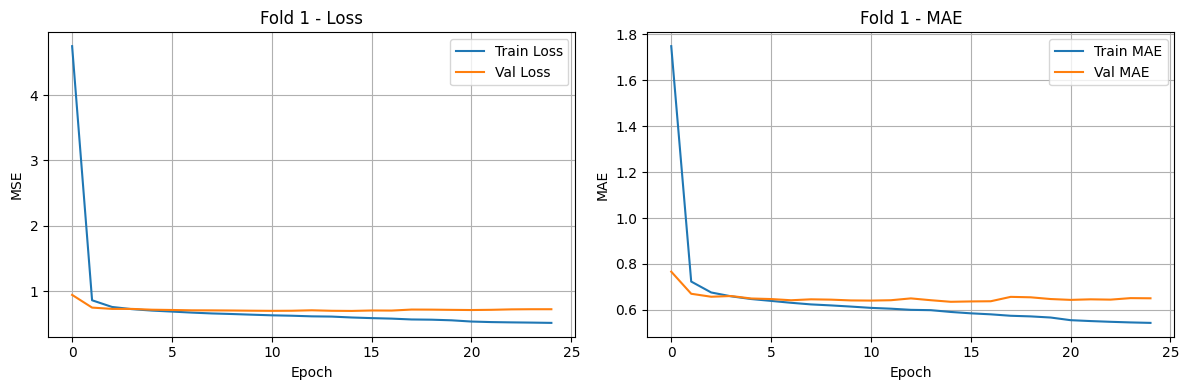

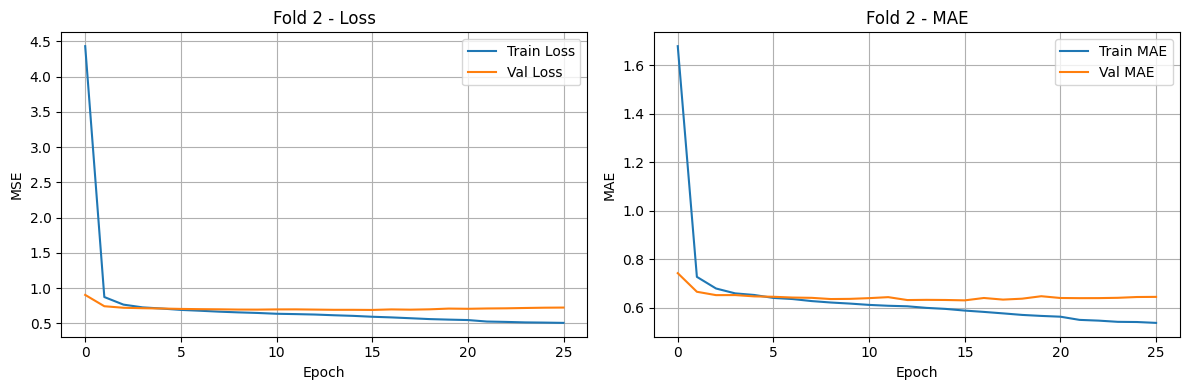

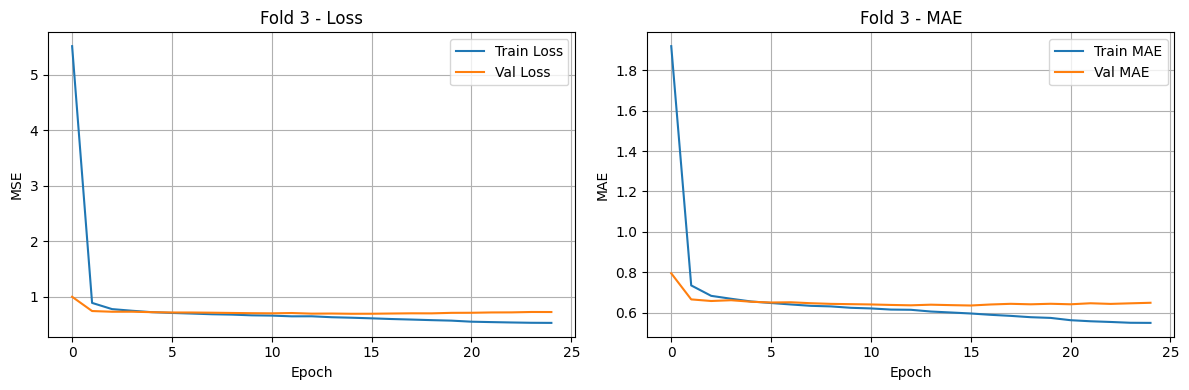

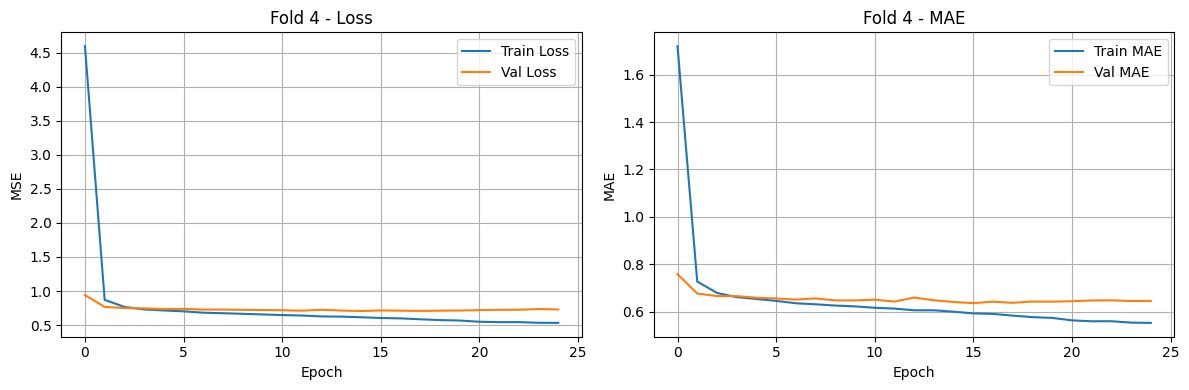

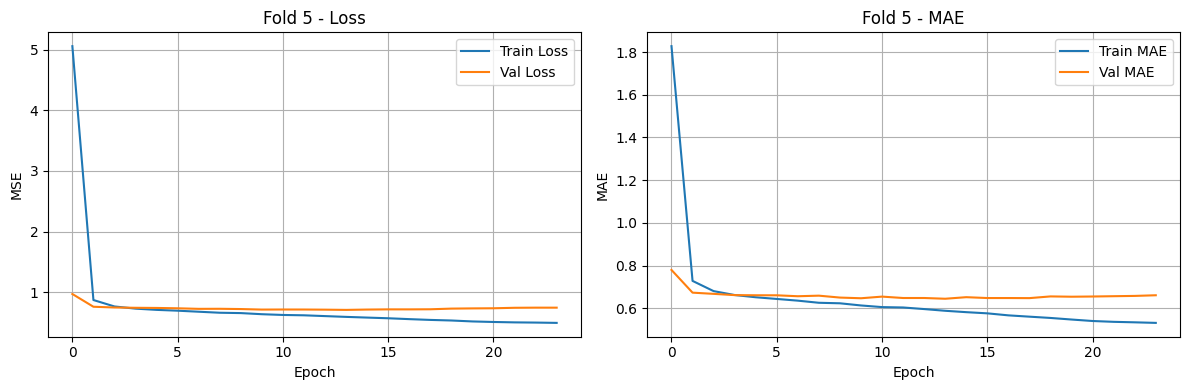

In [32]:
for i, history in enumerate(fold_histories):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Selanjutnya saya menggunakan **plot history** untuk melihat **performa model selama proses pelatihan pada setiap fold** secara visual. Plot ini sangat penting untuk:

### 1. **Memantau Konvergensi Model**

* Dari grafik **MSE (Loss)** di kiri, kita dapat melihat bahwa baik *train loss* maupun *validation loss* menurun dengan jumlah epoch.
* Hal ini menunjukkan bahwa model belajar dari data secara bertahap dan tidak mengalami stagnasi atau divergensi.

### 2. **Mendeteksi Overfitting**

* Dengan membandingkan **train MAE vs validation MAE** di grafik kanan, kita bisa memantau apakah model mulai terlalu "menghapal" data latih.
* Pada grafik Fold 1, terlihat bahwa **selisih antara train MAE dan val MAE tidak terlalu besar**, sehingga **indikasi overfitting masih kecil**.
* Meski di epoch akhir val MAE sedikit naik, tapi trennya **masih cukup stabil**.

### 3. **Menentukan Jumlah Epoch Ideal**

* Plot ini juga membantu memverifikasi bahwa strategi **EarlyStopping** berjalan dengan baik.
* Kita bisa melihat bahwa model mulai mencapai titik stabil setelah sekitar 10–15 epoch.

### Kesimpulan Sementara dari Plot Fold 1:

* Model menunjukkan **proses belajar yang sehat dan stabil**.
* Tidak ada tanda overfitting yang drastis.
* Validasi loss dan MAE tidak meningkat tajam meskipun epoch bertambah.

In [33]:
# Save full model (architecture + weights + optimizer state)
model.save("../models/final_model.keras")


Setelah dirasa model sudah cukup baik berdasarkan hasil evaluasi dan visualisasi learning curve, **saya menyimpannya di folder `../models/` dengan nama `final_model.keras`** dalam bentuk:

### ✅ **Full Model Format dari Keras**

Model disimpan dalam format `.keras`, yang mencakup:

1. **Arsitektur model**,
2. **Bobot hasil training**, dan
3. **State dari optimizer** (misalnya, posisi learning rate terakhir, dll).

Format ini sangat berguna karena memungkinkan:

* **Load kembali model secara utuh** tanpa perlu menyusun ulang struktur layer,
* **Langsung digunakan untuk prediksi (inference)** atau melanjutkan pelatihan (fine-tuning),
* **Mudah dipindahkan dan digunakan di environment lain**.


In [34]:
loaded_model = keras.models.load_model("../models/final_model.keras")

Karena keperluan **inference** atau **pengujian akhir**, saya **meng-load kembali model yang sebelumnya telah saya simpan** menggunakan perintah:

```python
loaded_model = keras.models.load_model("../models/final_model.keras")
```

Dengan memuat model ini, saya dapat:

* Melakukan **prediksi terhadap data baru atau data uji** tanpa perlu melatih ulang model,
* Memastikan bahwa **hasil prediksi tetap konsisten** dengan model yang telah dilatih,
* Menyederhanakan proses deployment karena model sudah dalam format siap pakai.

Langkah ini penting untuk memastikan bahwa **model yang digunakan untuk evaluasi akhir dan/atau produksi** adalah versi terbaik yang telah disimpan berdasarkan performa validasi.

In [35]:
# Netflix-style Recommendation Display in Notebook (tanpa def)

# Pilih userId (yang asli)
target_user_id = 1  # Ganti dengan userId valid dari dataset

if target_user_id not in user_id_to_encoded:
    print(f"❌ User ID {target_user_id} tidak ditemukan.")
else:
    user_enc = user_id_to_encoded[target_user_id]
    
    # Ambil semua movieId
    all_movie_ids = movie_metadata.index.tolist()
    user_watched = data[data['userId'] == target_user_id]['movieId'].tolist()
    candidate_movie_ids = [mid for mid in all_movie_ids if mid not in user_watched]

    if not candidate_movie_ids:
        print(f"🎯 User {target_user_id} telah menonton semua film yang tersedia.")
    else:
        movie_encodings = [movie_id_to_encoded[mid] for mid in candidate_movie_ids]
        user_array = np.array([user_enc] * len(candidate_movie_ids))
        movie_array = np.array(movie_encodings)

        movie_ratings = np.array([
            movie_metadata.loc[mid]['movie_rating'] for mid in candidate_movie_ids
        ]).reshape(-1, 1)
        years = np.array([
            movie_metadata.loc[mid]['year'] for mid in candidate_movie_ids
        ]).reshape(-1, 1)

        movie_rating_scaled = scaler_movie_rating.transform(movie_ratings)
        year_scaled = scaler_year.transform(years)

        predicted_ratings = loaded_model.predict([
            user_array, movie_array,
            movie_rating_scaled.flatten(), year_scaled.flatten()
        ]).flatten()

        # Gabungkan hasil ke dalam DataFrame
        results = pd.DataFrame({
            'movieId': candidate_movie_ids,
            'predicted_rating': predicted_ratings
        })
        results['title'] = results['movieId'].map(movie_metadata['title'])
        results['year'] = results['movieId'].map(movie_metadata['year'])
        results['imdb_rating'] = results['movieId'].map(movie_metadata['movie_rating'])
        results['genres'] = results['movieId'].map(movie_metadata['genres'])

        # Ambil Top 10
        top_n_df = results.sort_values(by='predicted_rating', ascending=False).head(10)

        # Tampilkan dengan gaya Netflix
        print(f"\n🎬 NETFLIX-STYLE RECOMMENDATIONS FOR USER {target_user_id}")
        print("=" * 80)
        for i, row in enumerate(top_n_df.itertuples(), 1):
            print(f"{i:2d}. 🎬 {row.title} ({int(row.year)})")
            print(f"    ⭐ IMDB: {round(row.imdb_rating, 1)}/10 | 🎭 {row.genres}")
            print()

        print(f"📊 Evaluated {len(candidate_movie_ids)} movies")
        print(f"🎯 Found {len(top_n_df)} good matches")


  1/297 [..............................] - ETA: 27s

c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


297/297 [==============================] - 0s 1ms/step

🎬 NETFLIX-STYLE RECOMMENDATIONS FOR USER 1
 1. 🎬 villain (1971)
    ⭐ IMDB: 5.0/10 | 🎭 crime,drama,thriller

 2. 🎬 down argentine way (1940)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,drama,romance

 3. 🎬 goodbye charlie (1964)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,fantasy,romance

 4. 🎬 hollywood chainsaw hookers (1988)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,horror

 5. 🎬 girls about town (1931)
    ⭐ IMDB: 5.0/10 | 🎭 comedy

 6. 🎬 tales of manhattan (1942)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,drama

 7. 🎬 little murders (1971)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,crime

 8. 🎬 boy eats girl (2005)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,horror

 9. 🎬 sun alley (sonnenallee) (1999)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,romance

10. 🎬 mickey's once upon a christmas (1999)
    ⭐ IMDB: 5.0/10 | 🎭 animation,comedy,fantasy

📊 Evaluated 9479 movies
🎯 Found 10 good matches


Terakhir, proses *inference testing* saya coba kepada `user_id = 1` dan memperoleh **10 rekomendasi film teratas** yang belum ditonton oleh user tersebut, berdasarkan prediksi rating tertinggi dari model. Proses ini melibatkan beberapa langkah sebagai berikut:

1. **Validasi user**
   Dicek apakah `user_id` tersebut ada di dalam dataset. Jika tidak ditemukan, proses dihentikan dengan pesan kesalahan.

2. **Pemilahan kandidat film**
   Daftar seluruh `movieId` diambil dari metadata, lalu difilter untuk mengeluarkan film yang sudah ditonton oleh user. Hasilnya adalah *candidate movies*.

3. **Encoding dan normalisasi fitur**

   * `user_id` dan `movie_id` dikonversi menjadi representasi numerik (encoded).
   * Fitur `movie_rating` dan `year` dinormalisasi menggunakan `scaler_movie_rating` dan `scaler_year` agar sesuai dengan distribusi data pelatihan model.

4. **Prediksi rating**
   Model yang sudah dilatih (`loaded_model`) digunakan untuk memprediksi rating dari user terhadap setiap kandidat film. Model ini menerima input berupa pasangan `(user_id, movie_id)` serta fitur tambahan (`rating`, `year`).

5. **Penyusunan hasil**
   Semua hasil prediksi dimasukkan ke dalam DataFrame yang berisi:

   * `movieId`
   * `predicted_rating`
   * `title`, `year`, `imdb_rating`, dan `genres` (dari metadata)

6. **Pengambilan rekomendasi teratas**
   DataFrame diurutkan berdasarkan `predicted_rating` secara menurun dan diambil 10 teratas.

7. **Tampilan gaya Netflix**
   Hasil akhir ditampilkan dalam format yang menyerupai rekomendasi ala Netflix, dengan menampilkan judul, tahun, rating IMDb, dan genre.

Sebanyak **9479 film** dievaluasi, dan **10 film** direkomendasikan sebagai *match* terbaik untuk `user_id = 1`. Model juga menunjukkan performa evaluasi yang cukup baik dengan nilai **RMSE sebesar 0.8062** dan **MAE sebesar 0.6153**, yang mengindikasikan bahwa rata-rata prediksi model cukup mendekati rating sebenarnya.
